In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Colab Data/complaints.csv.zip')
df.iloc[:,:10].head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code
0,2019-09-24,Debt collection,I do not know,Attempts to collect debt not owed,Debt is not yours,transworld systems inc. \nis trying to collect...,NaN,TRANSWORLD SYSTEMS INC,FL,335XX
1,2019-09-19,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,PA,15206
2,2019-11-08,Debt collection,I do not know,Communication tactics,Frequent or repeated calls,"Over the past 2 weeks, I have been receiving e...",NaN,"Diversified Consultants, Inc.",NC,275XX
3,2019-09-15,Debt collection,Other debt,Attempts to collect debt not owed,Debt was result of identity theft,Pioneer has committed several federal violatio...,NaN,Pioneer Capital Solutions Inc,CA,925XX
4,2021-03-02,"Credit reporting, credit repair services, or o...",Credit reporting,Incorrect information on your report,Information belongs to someone else,NaN,NaN,"EQUIFAX, INC.",FL,33325


In [7]:
df = df[pd.notnull(df['Consumer complaint narrative'])]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679285 entries, 0 to 1999963
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 679285 non-null  object
 1   Product                       679285 non-null  object
 2   Sub-product                   627113 non-null  object
 3   Issue                         679285 non-null  object
 4   Sub-issue                     528206 non-null  object
 5   Consumer complaint narrative  679285 non-null  object
 6   Company public response       339012 non-null  object
 7   Company                       679285 non-null  object
 8   State                         675680 non-null  object
 9   ZIP code                      528244 non-null  object
 10  Tags                          111909 non-null  object
 11  Consumer consent provided?    679285 non-null  object
 12  Submitted via                 679285 non-null  object
 13

In [9]:
col = ['Product', 'Consumer complaint narrative']
df = df[col]

In [10]:
df.columns

Index(['Product', 'Consumer complaint narrative'], dtype='object')

In [11]:
df.columns = ['Product', 'Consumer_complaint_narrative']

In [12]:
df['category_id'] = df['Product'].factorize()[0]

In [13]:
from io import StringIO
category_id_df = df[['Product', 'category_id']].drop_duplicates().sort_values('category_id')

# Mapping Dictionaries
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

In [14]:
df.head()

,Product,Consumer_complaint_narrative,category_id
0,Debt collection,transworld systems inc. \nis trying to collect...,0
2,Debt collection,"Over the past 2 weeks, I have been receiving e...",0
3,Debt collection,Pioneer has committed several federal violatio...,0
8,"Credit reporting, credit repair services, or o...","Previously, on XX/XX/XXXX, XX/XX/XXXX, and XX/...",1
9,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...,1


In [15]:
import sys
sys.getsizeof(df)/(1024**3)

0.7826486974954605

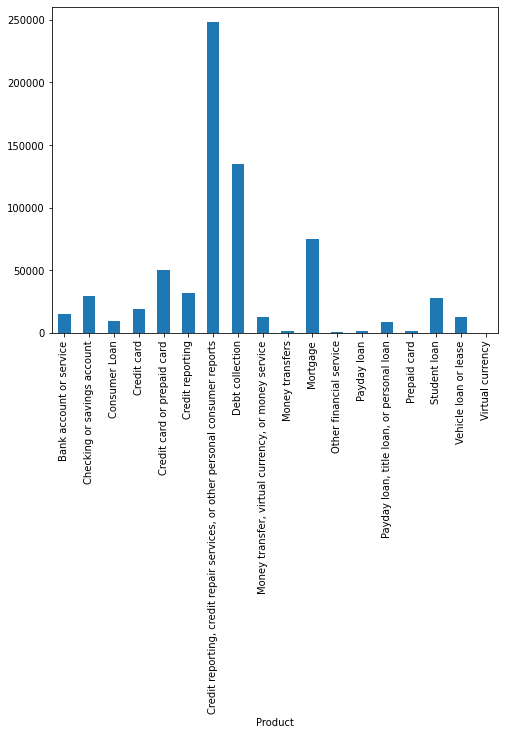

In [16]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

# Undersample the High Frequency Classes - Using Median Count

In [17]:
df['Product'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    248115
Debt collection                                                                 134651
Mortgage                                                                         75042
Credit card or prepaid card                                                      50365
Credit reporting                                                                 31588
Checking or savings account                                                      29404
Student loan                                                                     27735
Credit card                                                                      18838
Bank account or service                                                          14885
Money transfer, virtual currency, or money service                               12994
Vehicle loan or lease                                                            12287
Consumer Loan                              

In [18]:
print('Minority Class Count : ', df['Product'].value_counts().min())
print('Majority Class Count : ', df['Product'].value_counts().max())

Minority Class Count :  16
Majority Class Count :  248115


In [19]:
# Percentage of majority relative to the minority class
samplingStrategy = 0.01

In [20]:
import numpy as np

# Undersampling using sampling strategy 
nsamples_per_class = np.int16(df['Product'].value_counts().min()/samplingStrategy)
undersample = lambda df: df.loc[np.random.choice(a=df.index, size=min(len(df.index), nsamples_per_class), replace=False)]
df_bal = df.groupby(['Product'], as_index=False).apply(undersample)

print(df_bal.shape)

(25655, 3)


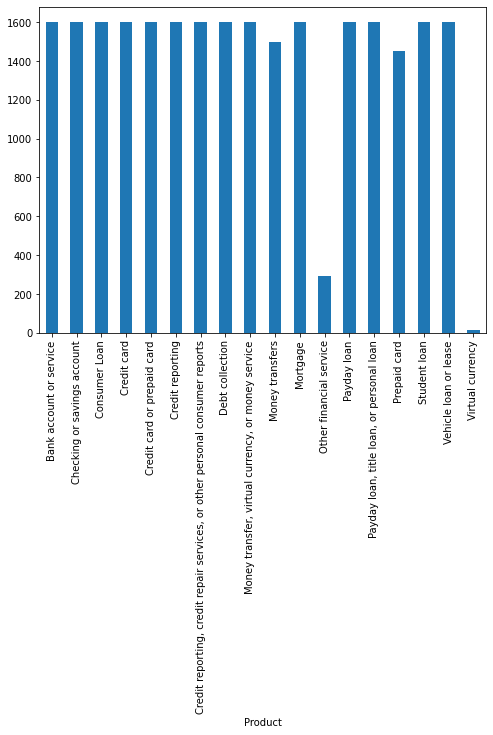

In [21]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_bal.groupby('Product').Consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [22]:
df = df_bal

In [23]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-13 23:54:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-13 23:54:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-13 23:54:32--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [28]:
import zipfile
zip_ref = zipfile.ZipFile("glove.6B.zip", 'r')
zip_ref.extractall('/content/drive/MyDrive/Colab Data/')
zip_ref.close()

In [25]:
import numpy as np

with open('/content/drive/MyDrive/Colab Data/glove.6B.100d.txt', "rb") as lines:
  w2v = {line.split()[0]: np.array(map(float, line.split()[1:])) for line in lines}

In [26]:
import spacy
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner"])

In [29]:
def preprocess(text):
    doc = nlp(text)     # Tokenize the text
    doc = filter(lambda token: token.is_stop == False, doc)     # Remove the stop words
    doc = [token.lemma_ for token in doc if token.lemma_.isalpha() == True]    # Lemmatize and filter out lemmas containing non-alphabetical characters
    return doc

In [30]:
import gensim

tokens = df['Consumer_complaint_narrative'].apply(preprocess)

# let X be a list of tokenized texts (i.e. list of lists of tokens)
model = gensim.models.Word2Vec(list(tokens), size=100)
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  import sys


In [31]:
import itertools


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(itertools.chain(word2vec.values()).__next__())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [32]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(itertools.chain(word2vec.values()).__next__())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier
from collections import Counter, defaultdict

etree_w2v = Pipeline([("word2vec", MeanEmbeddingVectorizer(w2v)),
                      ("extra trees", ExtraTreesClassifier(n_estimators=100))])

etree_w2v_tfidf = Pipeline([("word2vec", TfidfEmbeddingVectorizer(w2v)),
                            ("extra trees", ExtraTreesClassifier(n_estimators=100))])

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(tokens, df['Product'], random_state = 0)
etree_w2v_tfidf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('word2vec',
                 <__main__.TfidfEmbeddingVectorizer object at 0x7f20b6115650>),
                ('extra trees',
                 ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                                      class_weight=None, criterion='gini',
                                      max_depth=None, max_features='auto',
                                      max_leaf_nodes=None, max_samples=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=100, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False))],
         verbose=False)

In [47]:
y_pred = etree_w2v_tfidf.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.41      0.42      0.41       402
                                                 Checking or savings account       0.38      0.38      0.38       405
                                                               Consumer Loan       0.28      0.19      0.23       370
                                                                 Credit card       0.38      0.38      0.38       412
                                                 Credit card or prepaid card       0.34      0.29      0.31       401
                                                            Credit reporting       0.45      0.58      0.50       409
Credit reporting, credit repair services, or other personal consumer reports       0.44      0.47      0.45       386
                                                       

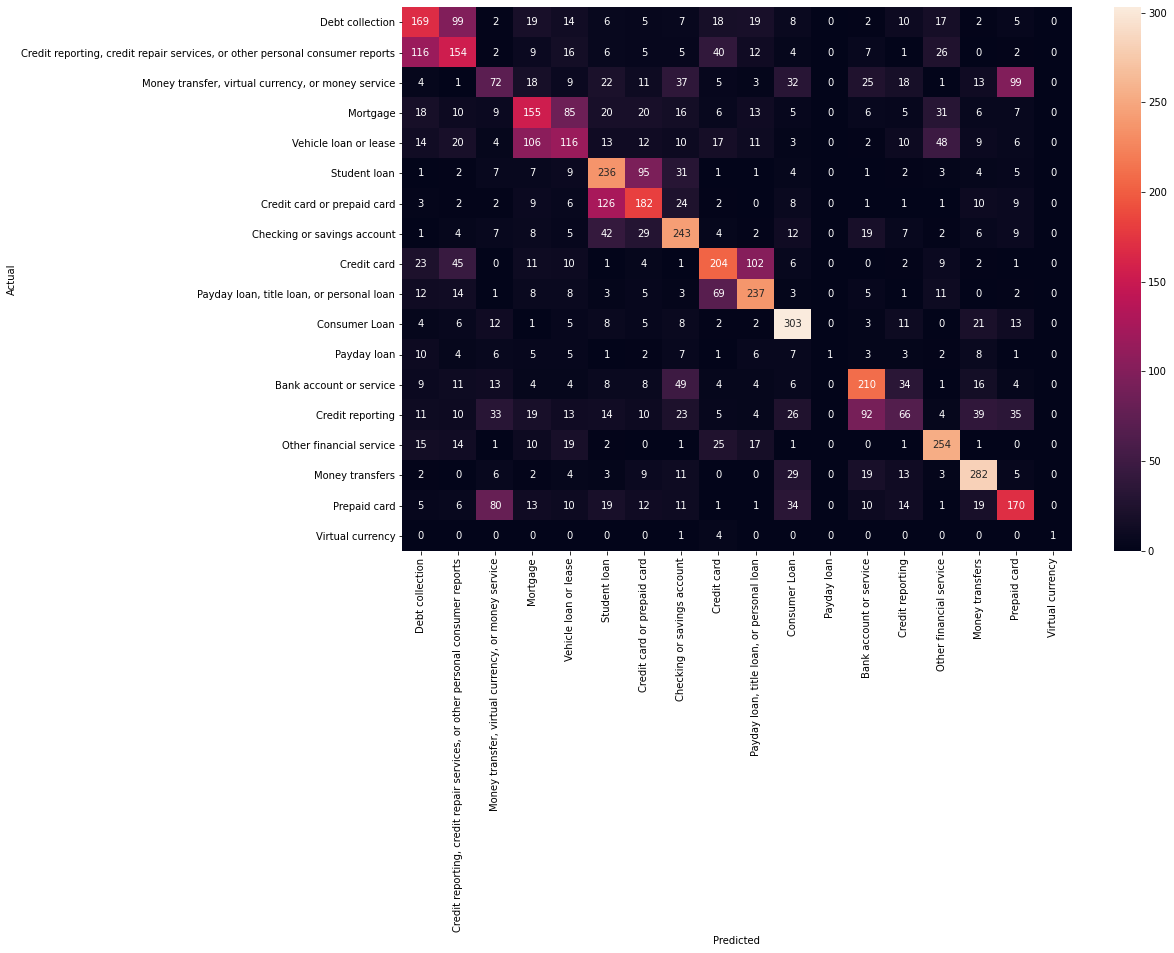

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [49]:
from sklearn import metrics
metrics.f1_score(y_test, y_pred, average='weighted')

0.46245892200183436

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

## Linear Support Vector Machine Classifier

In [ ]:
pipe = Pipeline([("word2vec", MeanEmbeddingVectorizer(w2v)), 
                 ('SVC', LinearSVC())])
pipe.fit(X_train, y_train)

In [57]:
# Evaluate the Linear SVC classifier
y_pred = pipe.predict(X_test)
print(classification_report(y_test, y_pred))

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.43      0.48      0.45       402
                                                 Checking or savings account       0.47      0.37      0.41       405
                                                               Consumer Loan       0.31      0.14      0.19       370
                                                                 Credit card       0.45      0.48      0.46       412
                                                 Credit card or prepaid card       0.41      0.24      0.30       401
                                                            Credit reporting       0.48      0.54      0.50       409
Credit reporting, credit repair services, or other personal consumer reports       0.39      0.41      0.40       386
                                                       

In [58]:
metrics.f1_score(y_test, y_pred, average='weighted')

0.47796123631658566